# Layer Normalization

## LN 为了解决什么问题？
我们知道，batch normalization 是一种解决 Internal Covariate Shift 的近似方法，它的优点是可以**加速训练**,**不需要很小心地初始化参数**,以及**缓解过拟合**。

但是它的缺点也同样明显：
1. 当 batch size 比较小的时候，均值和方差的计算就没有很好的统计意义。
2. 对于 rnn 网络结构，由于序列长度不一致，导致 bn 不能很好地适用。

Layer Normalization 可以解决上述两个问题。

## LN 理解
现在主流的 normalization 都可以抽象成下面的框架：
$a' = \frac{\beta}{\sigma}(a - \mu) + b$

其中，$a$ 是在激活函数之前的输入（文中的 summed input），$\beta$ 和 $b$ 是新引入的参数，分别是 re-scale 参数和 re-center 参数。 而均值 $\mu$ 和方差 $\sigma$ 的计算，不同 normalization 方法各有不同。

关于 LN 和 BN 的区别，可以见下表：

 | Layer Normalization | Batch Normalization
--- | ---- | ---
均值和方差计算 | 每一层的神经元整体计算均值和方差，每个样本单独计算 | 单个神经元单独计算其关于 mini-batch 的均值和方差
参数矩阵 re-scale | 不变 | 不变
参数矩阵 re-center | 不变 | 变
参数向量 re-scale | 变 | 不变
数据集 re-scale | 不变 | 不变
数据集 re-center | 变 | 不变
单个训练数据 re-scale | 不变 |变

其实论文中第5.2节关于训练中参数空间的分析并没有看懂。。。看了许多资料也没能理解。

## LN 的优势

其实 BN 的劣势就是 LN 的优势，即可以用在 batch size 比较小的时候，比如 online learning 的时候。还有就是在 rnn 中适用。

## LN 的劣势
文中提到 LN 在 cnn 中的表现是：比 baseline 收敛快，但是效果比 BN 差。作者认为是因为在全连接中，hidden layer 的每个单元对输出的贡献是相似的，而在 cnn 中这个假设不成立（不懂。。）

## Reference
* [Layer Normalization](https://arxiv.org/pdf/1607.06450.pdf)
* [详解深度学习中的Normalization，BN/LN/WN](https://zhuanlan.zhihu.com/p/33173246)

## 在 MNIST 数据集上测试 LN, BN 以及没有 normalization (baseline) 的效果

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MINIST_data/', one_hot=True)

Extracting MINIST_data/train-images-idx3-ubyte.gz
Extracting MINIST_data/train-labels-idx1-ubyte.gz
Extracting MINIST_data/t10k-images-idx3-ubyte.gz
Extracting MINIST_data/t10k-labels-idx1-ubyte.gz


In [28]:
class ANN:
    def __init__(self, norm_method, learning_rate, num_layers=3, hidden_size=100):
        assert norm_method in [None, 'bn', 'ln']
        
        self.x = tf.placeholder(tf.float32, shape=(None, 784))
        self.labels = tf.placeholder(tf.float32, shape=[None, 10])
        self.is_training = tf.placeholder(tf.bool)
        self.global_step = tf.Variable(0, trainable=False)
        
        # Hidden layers.
        with tf.name_scope('hidden'):
            layer_output = self.x
            for i in range(num_layers):
                layer_output = self._full_connect(layer_output, hidden_size, norm_method)
        
        # Output layer.
        with tf.name_scope('output'):
            self.logits = self._full_connect(layer_output, 10, False)

        # Loss
        with tf.name_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=self.labels, logits=self.logits))
            if norm_method == 'bn':
                with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
                    self.optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(self.loss, global_step=self.global_step)
            else:
                self.optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(self.loss, global_step=self.global_step)
        
        # Accuracy
        with tf.name_scope('accuracy'):
            self.predicts = tf.argmax(self.logits, 1)
            self.true_labels = tf.argmax(self.labels, 1)
            self.accuracy = tf.reduce_mean(tf.cast(tf.equal(self.predicts, self.true_labels), tf.float32))
        
    def _full_connect(self, _input, output_size, norm_method):
        input_size = _input.shape[1].value
        init_weights = tf.random.normal([input_size, output_size])
        init_bias = tf.zeros([output_size])
        weights = tf.Variable(init_weights, trainable=True)
        bias = tf.Variable(init_bias, trainable=True)
        linear_output = tf.add(tf.matmul(_input, weights), bias)
        if norm_method == 'bn':
            linear_output = tf.layers.batch_normalization(linear_output, training=self.is_training)
        elif norm_method == 'ln':
            linear_output = tf.contrib.layers.layer_norm(linear_output)
        return tf.nn.sigmoid(linear_output)


def train(norm_method,
          batch_size=60,
          num_steps=50000,
          learning_rate=0.5,
          test_every_steps=500):
    steps = []
    test_acc = []

    with tf.Session() as sess:
        model = ANN(norm_method, learning_rate)
        sess.run(tf.global_variables_initializer())
        
        for i in tqdm(range(num_steps)):
            batch_x, batch_y = mnist.train.next_batch(batch_size)
            feed_dict = {
                model.x: batch_x,
                model.labels: batch_y,
                model.is_training: True
            }
            _, step, loss, train_accuracy = sess.run(
                [model.optimizer, model.global_step, model.loss, model.accuracy],
                feed_dict=feed_dict)
            
            if step % test_every_steps == 0:
                accuracy = sess.run(model.accuracy, feed_dict={
                    model.x: mnist.test.images,
                    model.labels: mnist.test.labels,
                    model.is_training: False
                })
                steps.append(step)
                test_acc.append(accuracy)
    return test_acc, steps
                
def plot(data, title):
    fig, ax = plt.subplots()
    for test_acc, steps, label in data:
        ax.plot(steps, test_acc, label=label)
    ax.set_xlabel('train steps')
    ax.set_ylabel('test accuracy')
    ax.set_title(title)
    ax.legend(loc=4)
    ax.set_ylim([0, 1])
    plt.show()

<IPython.core.display.Javascript object>


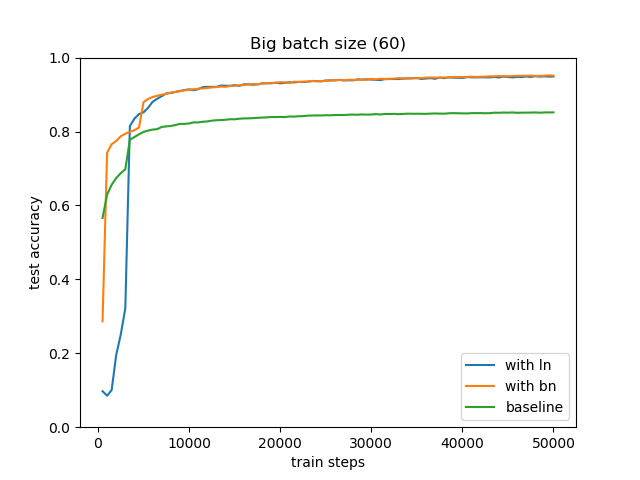

In [29]:
def run():
    cases = [('ln', 'with ln'), ('bn', 'with bn'), (None, 'baseline')]
    data = []
    for norm_method, label in cases:
        test_acc, steps = train(norm_method, batch_size=60, num_steps=50000)
        data.append((test_acc, steps, label))
        tf.reset_default_graph()
    plot(data, 'Big batch size (60)')
    
run()

<IPython.core.display.Javascript object>


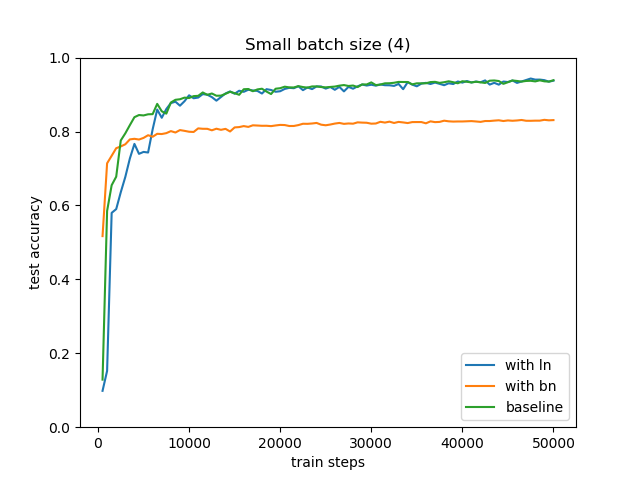

In [34]:
def run():
    cases = [('ln', 'with ln'), ('bn', 'with bn'), (None, 'baseline')]
    data = []
    for norm_method, label in cases:
        test_acc, steps = train(norm_method, batch_size=4, num_steps=50000)
        data.append((test_acc, steps, label))
        tf.reset_default_graph()
    plot(data, "Small batch size (4)")
    
run()

## 总结

上面两个实验可以发现：
1. 当 batch size 较大时，ln 和 bn 的效果差不多，且都比 baseline好。
2. 当 batch size 较小时，bn 效果明显下降，比 baseline 还差，而 ln 好像和 baseline 不相上下。。